In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import backend as K
import gc
from keras.models import Model
import pickle

In [2]:
train_dir="/kaggle/input/signature-verification-dataset/sign_data/train/"
test_dir="/kaggle/input/signature-verification-dataset/sign_data/test/"

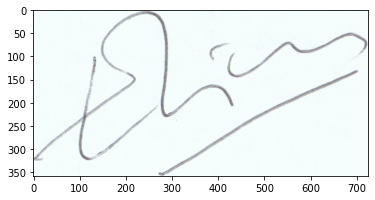

In [3]:
import matplotlib.pyplot as plt
img = plt.imread('../input/signature-verification-dataset/sign_data/train/001/001_01.PNG')
plt.imshow(img)

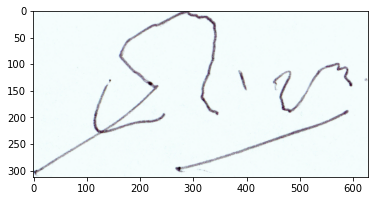

In [4]:
img1 = plt.imread('../input/signature-verification-dataset/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)

In [5]:
SIZE = 224

In [6]:
import cv2
import os
import glob

train_data_names = []
test_data_names = []

train_data = []
train_labels = []

for per in os.listdir('../input/signature-verification-dataset/sign_data/train/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/train/'+per+'/*.*'):
        train_data_names.append(data)
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data

test_data = []
test_labels = []

for per in os.listdir('../input/signature-verification-dataset/sign_data/test/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/test/'+per+'/*.*'):
        test_data_names.append(data)
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [7]:
with open('./train_data_names.pkl', 'wb') as fp:
    pickle.dump(train_data_names, fp)

with open('./test_data_names.pkl', 'wb') as fp:
    pickle.dump(test_data_names, fp)

In [8]:
# Categorical labels
train_labels = to_categorical(train_labels)
print(train_data.shape)
# Reshaping
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

(1649, 1, 224, 224, 3)


# Parameters

In [9]:
input_ = (224,224,3)
EPOCHS = 20
BS = 64
output_ = 2

# VGG16 - Adam

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [=========================

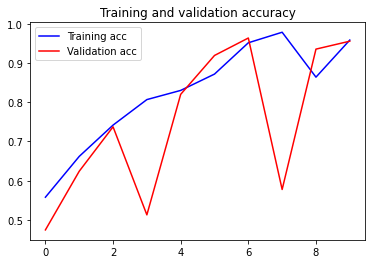

<Figure size 432x288 with 0 Axes>

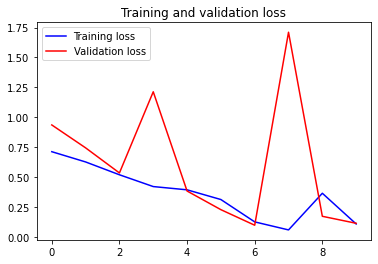

In [10]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./VGG16_Adam_train', intermediate_output_train)
np.save('./VGG16_Adam_test', intermediate_output_test)

# VGG16 - SGD

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 435ms/step - loss: 0.7077 - accuracy: 0.5234 - val_lo

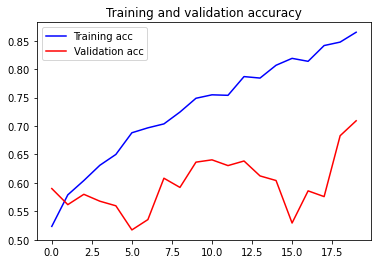

<Figure size 432x288 with 0 Axes>

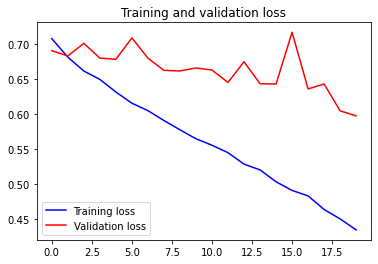

In [11]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./VGG16_SGD_train', intermediate_output_train)
np.save('./VGG16_SGD_test', intermediate_output_test)

# VGG16 - RMSprop

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 444ms/step - loss: 1.0334 - accuracy: 0.5416 - val_lo

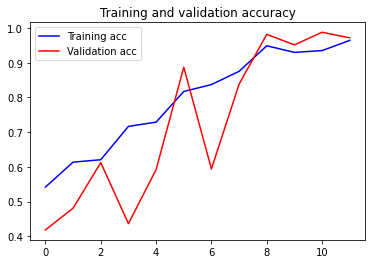

<Figure size 432x288 with 0 Axes>

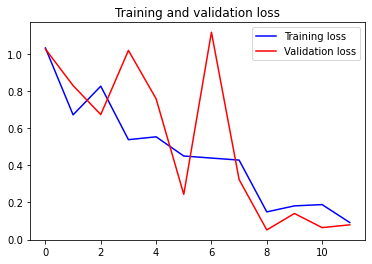

In [12]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./VGG16_RMSprop_train', intermediate_output_train)
np.save('./VGG16_RMSprop_test', intermediate_output_test)

# VGG16 - Adagrad

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 440ms/step - loss: 0.7539 - accuracy: 0.5182 - val_l

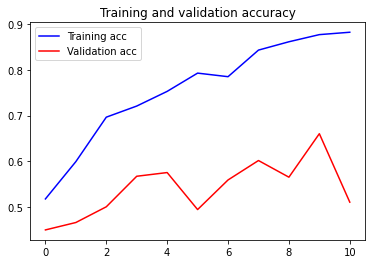

<Figure size 432x288 with 0 Axes>

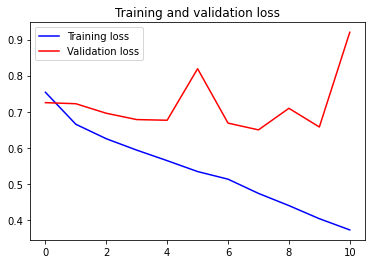

In [13]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./VGG16_Adagrad_train', intermediate_output_train)
np.save('./VGG16_Adagrad_test', intermediate_output_test)

# Inception_v3 - Adam

87916544/87910968 [==============================] - 0s 0us/step
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 34,910,754
Trainable params: 34,876,322
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
19/19 [===================

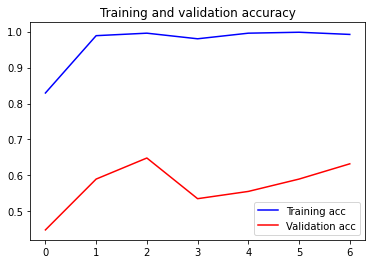

<Figure size 432x288 with 0 Axes>

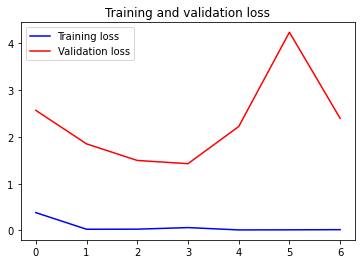

In [14]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./InceptionV3_Adam_train', intermediate_output_train)
np.save('./InceptionV3_Adam_test', intermediate_output_test)

# Inception_v3 - SGD

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 34,910,754
Trainable params: 34,876,322
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 7s 361ms/step - loss: 0.8254 - accuracy: 0.5009 - 

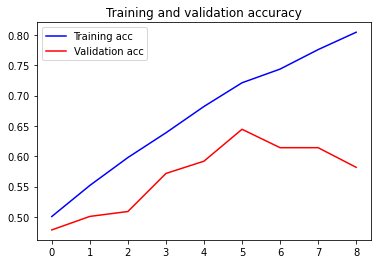

<Figure size 432x288 with 0 Axes>

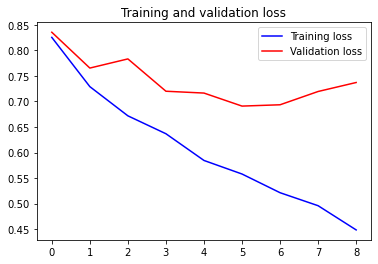

In [15]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./InceptionV3_SGD_train', intermediate_output_train)
np.save('./InceptionV3_SGD_test', intermediate_output_test)

# Inception_v3 - RMSprop

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 34,910,754
Trainable params: 34,876,322
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 7s 363ms/step - loss: 1.6017 - accuracy: 0.7348 - 

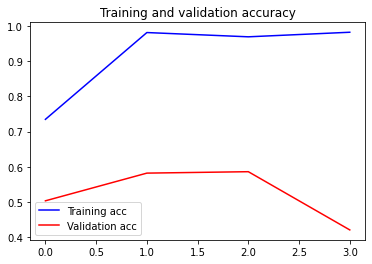

<Figure size 432x288 with 0 Axes>

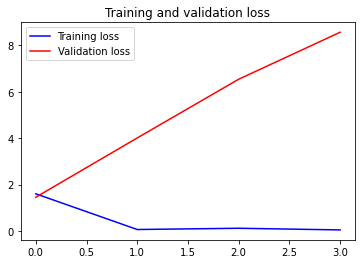

In [16]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./InceptionV3_RMSprop_train', intermediate_output_train)
np.save('./InceptionV3_RMSprop_test', intermediate_output_test)

# Inception_v3 - Adagrad

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 34,910,754
Trainable params: 34,876,322
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 7s 357ms/step - loss: 0.7507 - accuracy: 0.5407 - 

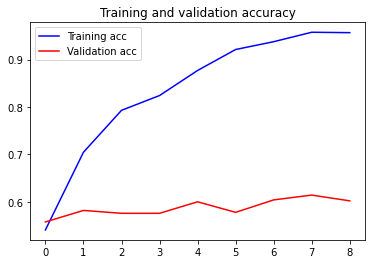

<Figure size 432x288 with 0 Axes>

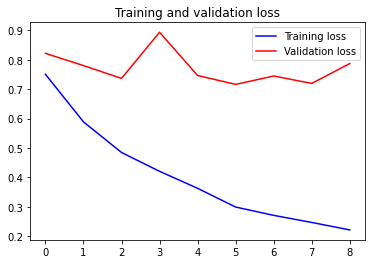

In [17]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./InceptionV3_Adagrad_train', intermediate_output_train)
np.save('./InceptionV3_Adagrad_test', intermediate_output_test)

# ResNet50 - Adam

94773248/94765736 [==============================] - 2s 0us/step
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
19/19 [===================

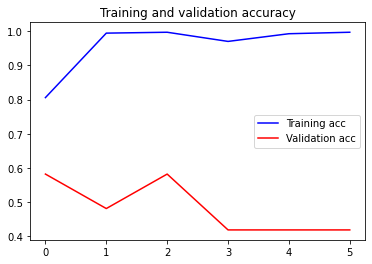

<Figure size 432x288 with 0 Axes>

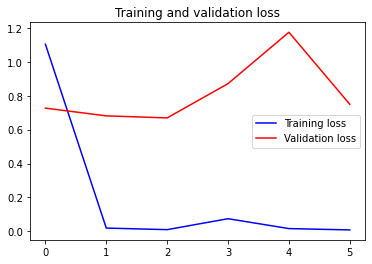

In [18]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./ResNet50_Adam_train', intermediate_output_train)
np.save('./ResNet50_Adam_test', intermediate_output_test)

# ResNet50 - SGD

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 396ms/step - loss: 0.9641 - accuracy: 0.5927 - 

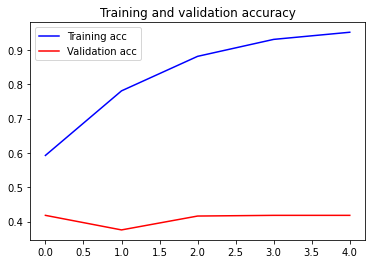

<Figure size 432x288 with 0 Axes>

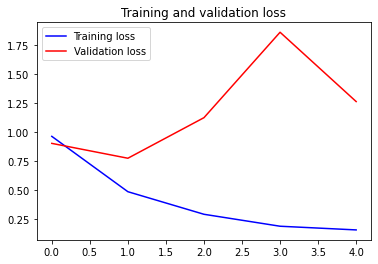

In [19]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./ResNet50_SGD_train', intermediate_output_train)
np.save('./ResNet50_SGD_test', intermediate_output_test)

# ResNet50 - RMSprop

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_10 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 514       
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 411ms/step - loss: 2.5199 - accuracy: 0.8423 - 

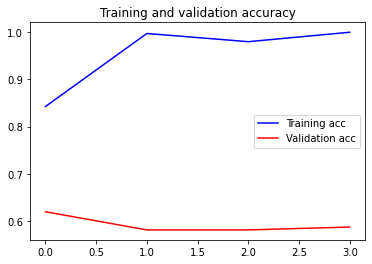

<Figure size 432x288 with 0 Axes>

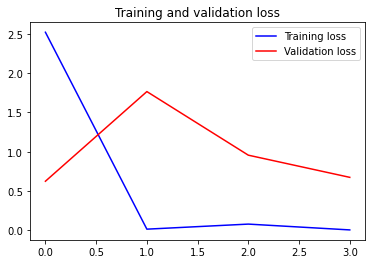

In [20]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./ResNet50_RMSprop_train', intermediate_output_train)
np.save('./ResNet50_RMSprop_test', intermediate_output_test)

# ResNet50 - Adagrad

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 514       
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 8s 399ms/step - loss: 0.7571 - accuracy: 0.6984 - 

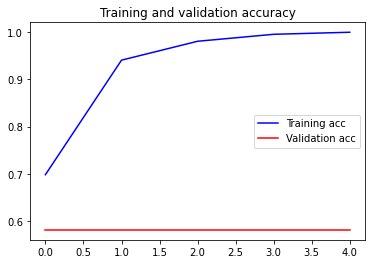

<Figure size 432x288 with 0 Axes>

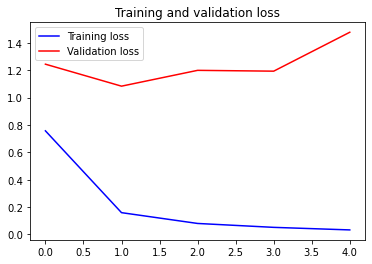

In [21]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./ResNet50_Adagrad_train', intermediate_output_train)
np.save('./ResNet50_Adagrad_test', intermediate_output_test)

# Xception - Adam

83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_12 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 514       
Total params: 46,552,362
Trainable params: 46,497,834
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/20
19/19 [===================

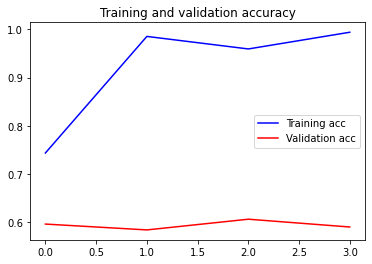

<Figure size 432x288 with 0 Axes>

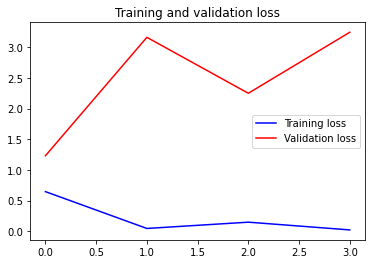

In [22]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./Xception_Adam_train', intermediate_output_train)
np.save('./Xception_Adam_test', intermediate_output_test)

# Xception - SGD

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_13 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 514       
Total params: 46,552,362
Trainable params: 46,497,834
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 16s 817ms/step - loss: 0.7043 - accuracy: 0.5459 -

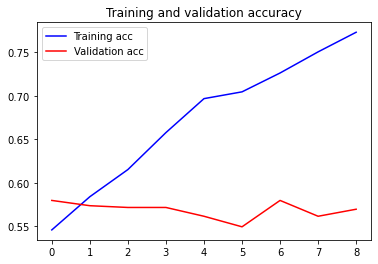

<Figure size 432x288 with 0 Axes>

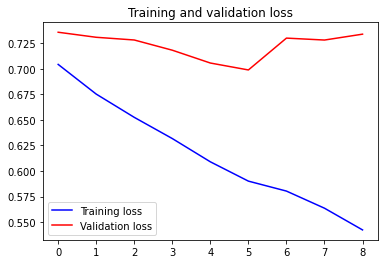

In [23]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./Xception_SGD_train', intermediate_output_train)
np.save('./Xception_SGD_test', intermediate_output_test)

# Xception - RMSprop

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_14 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 514       
Total params: 46,552,362
Trainable params: 46,497,834
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 15s 801ms/step - loss: 1.6578 - accuracy: 0.6785 -

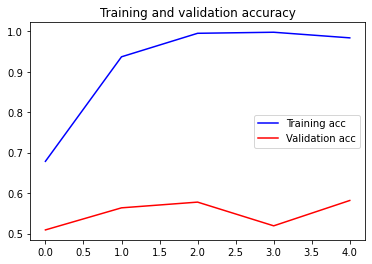

<Figure size 432x288 with 0 Axes>

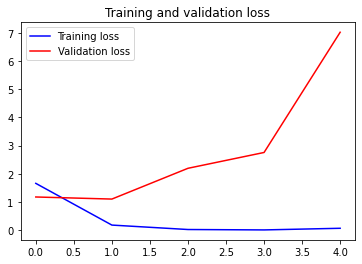

In [24]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./Xception_RMSprop_train', intermediate_output_train)
np.save('./Xception_RMSprop_test', intermediate_output_test)

# Xception - Adagrad

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_15 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 514       
Total params: 46,552,362
Trainable params: 46,497,834
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 15s 790ms/step - loss: 0.6700 - accuracy: 0.6023 -

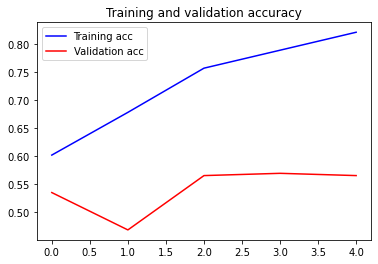

<Figure size 432x288 with 0 Axes>

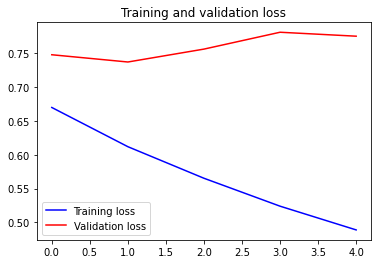

In [25]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_)

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(output_, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./Xception_Adagrad_train', intermediate_output_train)
np.save('./Xception_Adagrad_test', intermediate_output_test)